# Temperature Profile Classification - 2 Class system
GMM classification of Southern Ocean Argo float temperature profile data. This notebook uses a previously created model, PCA and sample data.<br><br>
### Dask import

In [1]:
#Dask setup cell
target_version='0.19.0'
!pip install xarray=={target_version} --upgrade #--upgrade

import logging
import subprocess
from dask.distributed import Client
from dask_gateway import Gateway
from distributed import WorkerPlugin

import dask
dask.config.set({"array.slicing.split_large_chunks": True})

class PipPlugin(WorkerPlugin):
    """ Install packages on a worker as it starts up.
 
    Parameters
    ----------
    packages : List[str] - A list of packages to install with pip on startup. """
    def __init__(self, packages):
        self.packages = packages
 
    def setup(self, worker):
        logger = logging.getLogger("distributed.worker")
        subprocess.call(['python', '-m', 'pip', 'install', '--upgrade'] + self.packages)
        logger.info("Installed %s", self.packages)
        
def check():
    import xarray
    return xarray.__version__

gateway = Gateway()

In [2]:
#Dask server launcher cell
if False:
    cluster = gateway.new_cluster(worker_memory=8)
    cluster.scale(20)
    client = Client(cluster)
    plugin = PipPlugin([f'xarray=={target_version}'])
    client.register_worker_plugin(plugin)

    print(client.run(check), "\n")
    client

In [3]:
if False:
    options = gateway.cluster_options()
    options.worker_cores = 4
    options.worker_memory = 8
    cluster = gateway.new_cluster(cluster_options=options)
    client = Client(cluster)
    plugin = PipPlugin([f'xarray=={target_version}'])
    client.register_worker_plugin(plugin)

    print(client.run(check), "\n")
    client

In [4]:
if False:
    client.close()
    cluster.close()

<br>

### Choices for data

In [5]:
#Experiment data for analysis
dataVariableId = 'thetao'
dataExperimentId = 'historical'
dataSourceId = 'UKESM1-0-LL'
dataInstitutionId = 'MOHC'
approvedIds = ["r1i1p1f2", "r2i1p1f2", "r3i1p1f2"] #insert start of approved member_ids

#File imports
maskName = "OceanMaskVolcello"
dataFileName = "GMMSampleDataUK1L.npy"
sampleFileName = "GMMSampleTimeGeoUK1.npy"
scalerName = "GMMScalerUK1L.bin"
modelName = "GMMUK2Class2"

#Data definitions
startDate = '1980-01'
endDate = '2009-12'
timeRange = slice(startDate, endDate)
levSel = slice(0, 2000) #Selected levels to be investigated
maxLat = -30 #Selected latitude to be investigated
runIdSel = 0

#Custom GMM variables
pcaNControl = 3 #set to int value to select, otherwise pcaThreshold is used to automatically assign value

<br>

### Libaries and Modules
Importing the necessary libaries and modules for the notebook.

In [6]:
#Import cell
import calendar
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import dask.dataframe as dd
import fsspec
import matplotlib.dates as mdates
import matplotlib as mpl ###
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.ticker as ticker
import xarray as xr
import zarr

from dask import config
from dask import delayed
from joblib import dump, load
from matplotlib.pyplot import cm
from sklearn import mixture
from sklearn.decomposition import PCA
from sklearn import preprocessing
from scipy import signal

config.set(**{'array.slicing.split_large_chunks': True})
print("Imports complete")

Imports complete


<br>

### Importing data sets
Importing the data for the models.

<b>Import sample data set and corresponding time/geo data</b>

In [7]:
sampleMetaDFL = pd.read_csv("GMMUK2Class2_Meta_Updated_31")
sampleMetaDFL = sampleMetaDFL.drop(columns=["Unnamed: 0"])
sampleMetaDFL["time"] = pd.to_datetime(sampleMetaDFL["time"])
print("Labeled sample meta data loaded and stored in sampleMetaDFL. "+ str(len(sampleMetaDFL)) +" samples loaded.")
sampleMetaDFL.head()

Labeled sample meta data loaded and stored in sampleMetaDFL. 2716200 samples loaded.


lat   lon       time  labelSorted  max posterior prob  \
0 -66.111520  73.5 1980-01-01            0                 1.0   
1 -64.439100  73.5 1980-01-01            0                 1.0   
2 -61.247692  73.5 1980-01-01            0                 1.0   
3 -60.270820  73.5 1980-01-01            0                 1.0   
4 -59.771150  73.5 1980-01-01            0                 1.0   

   classUncertainty  
0      5.435584e-09  
1      1.301537e-11  
2      4.247305e-09  
3      2.294754e-09  
4      1.220178e-09

In [8]:
#Meta data date processing cell
globalStartDate = sampleMetaDFL["time"][0]
globalDateInc = sampleMetaDFL["time"].unique()[1] - globalStartDate
globalEndDateIn = sampleMetaDFL["time"].iloc[-1]
globalEndDateOut = globalEndDateIn + globalDateInc

globalStartDateStr = str(globalStartDate)[:7]
globalEndDateInStr = str(globalEndDateIn)[:7]
globalEndDateOutStr = str(globalEndDateOut)[:7]
print("Sample meta data dates manipulated and stored in globalStartDate etc.")

Sample meta data dates manipulated and stored in globalStartDate etc.


<br>
<b>Loading ocean Masks</b>

In [9]:
#Ocean mask import cell
maskFile = xr.open_dataset(maskName)
oceanMask = maskFile.to_array()
maskFile = xr.open_dataset("OceanMaskUKESM1")
oceanMask2 = maskFile.to_array()
print("Mask Loaded and stored in oceanMask and oceanMask2 (volcello and UKESM).")

Mask Loaded and stored in oceanMask and oceanMask2 (volcello and UKESM).


<br>
<b>Unpacking ocean masks</b>

In [10]:
#Mask unpacking cell
geoRange = oceanMask #copying mask
geoRange = geoRange.rename({"variable":"cleanMe"}) #Dimension removal
geoRange = geoRange.sel(cleanMe = geoRange.cleanMe.values[0]) #Dimension removal
geoRange = geoRange.reset_coords("cleanMe", drop=True) #Dimension removal
geoRangeS = geoRange.stack(ij =("i", "j")) #Stacking
geoRangeFilt = geoRangeS.dropna("ij")
print("Ocean mask unpacked into geoRangeFilt.")

geoRange2 = oceanMask2 #copying mask
geoRange2S = geoRange2.stack(ij =("i", "j")) #Stacking
geoRangeFilt2 = geoRange2S.dropna("ij")
print("UKESM Ocean mask unpacked into geoRangeFilt2.")

Ocean mask unpacked into geoRangeFilt.
UKESM Ocean mask unpacked into geoRangeFilt2.


<br>
<b>Date Calculations</b>

In [11]:
#Date calculation cell
startDateNp = np.datetime64(startDate, 'M')
endDateNp = np.datetime64(endDate, 'M')
timeDiff = endDateNp - startDateNp
timeDiff = timeDiff.astype(int) + 1
print("Calculated date range.")

Calculated date range.


<br>

### Calculation functions
<b>Functions:</b><br>
<ul>
<li>pickRand - Takes in data frame and returns sampled data frame with a randomly selected number of rows from the input data frame, controled by the second input variable to the function.
<li>storeMeta - Returns a np array containing the latitude and longitude data for an input xarray and associated ij.
<li>loadModel - loadeds and returns GMM model named in input.
<li>saveModel - saves input GMM model to provided name, if no name provided default is GMMGenerated.
</ul>

In [12]:
#Calculation functions cell
def butter_lowpass(data,cut,order=4,sample_freq=1) :
    nyq = 0.5*sample_freq
    pass_freq =1./cut/nyq
    sos=signal.butter(order, pass_freq, 'low', output='sos')
    filt=signal.sosfiltfilt(sos,data)
    return filt

def pickRand(dataArray, sampleFactor):
    '''Returns a sample of the input array, size of sampled array is based on sampleFactor. For factor > 1 that many points are chosen, for factor < 1 that % is taken of the array'''
    arrLen = len(dataArray)
    if sampleFactor > 1:
        sampleSize = int(sampleFactor)
    elif sampleFactor > 0:
        sampleSize = int(sampleFactor*arrLen)
    else:
        return 1
    
    filtArr = np.zeros(arrLen, dtype=bool) # empty mask
    sampleId = np.random.choice(arrLen, sampleSize, False) # np array of randomly generated non repeating numbers
    for i in sampleId:
        filtArr[i] = True # populating mask
    return dataArray[filtArr] # applies mask


def pickRandMask(maskLen, maskQuantity, sampleFactor):
    '''Returns a linear mask for the input dimensions, size of mask is based on sampleFactor. For factor > 1 that many points are chosen, for factor < 1 that % is taken of the array'''
    if sampleFactor > 1:
        sampleSize = int(sampleFactor)
    elif sampleFactor > 0:
        sampleSize = int(sampleFactor*maskLen)
    else:
        return 1
    
    globalArr = np.empty(shape=(0), dtype=bool)
    for i in range(maskQuantity):
        filtArr = np.zeros(maskLen, dtype=bool) # empty mask
        sampleId = np.random.choice(maskLen, sampleSize, False) # np array of randomly generated non repeating numbers
        for j in sampleId:
            filtArr[j] = True # populating mask
        globalArr = np.append(globalArr, filtArr)
    return globalArr


def storeMeta(dataArray):
    '''Returns a np array containing the latitude and longitude data for the input xarray and the associated ij index'''
    storeLen = len(dataArray["lat"]) # assumes each lat has a corresponding lon
    storage = np.empty(shape=(0,storeLen))
    storage = np.append(storage, [dataArray["lat"].values], axis = 0)
    storage = np.append(storage, [dataArray["lon"].values], axis = 0)
    #storage = np.append(storage, [dataArray["time"].values], axis = 0)
    #storage = np.append(storage, [dataArray["ij"].values], axis = 0)
    return storage


def loadModel(modelName:str):
    '''Loades the input GMM model named in the functions input. Returns loaded model.'''
    means = np.load(modelName + '_means.npy')
    covar = np.load(modelName + '_covariances.npy')
    GMModel = mixture.GaussianMixture(n_components = len(means), covariance_type='full')
    GMModel.precisions_cholesky_ = np.linalg.cholesky(np.linalg.inv(covar))
    GMModel.weights_ = np.load(modelName + '_weights.npy')
    GMModel.means_ = means
    GMModel.covariances_ = covar
    return GMModel


def saveModel(GMModel, modelName = "GMMGenerated"):
    '''Saves the input GMM model's weights, means and covariances. Assigns input name if provided to model.'''
    GMModel_name = str(modelName)
    np.save(modelName + '_weights', GMModel.weights_, allow_pickle=False)
    np.save(modelName + '_means', GMModel.means_, allow_pickle=False)
    np.save(modelName + '_covariances', GMModel.covariances_, allow_pickle=False)
    return 0

print("Calculation functions defined.")

Calculation functions defined.


<br>

### Plotting functions
<b>Functions:</b>
<ul>
<li> locationPlotGroup - plots location and classification of data points for an input numpy array.
<li> locationPlotGroupDF - plots location and classification of data points for an input data frame.
<li> locationPlotGroupDFMonthly - plots location and classification of data points for an input data frame in monthly subplots.
<li> locationPlotTime - plots locations of an input data array on a map with a colour scale for time.
<li> locationPlotUncertaintyDF - plots uncertainty in classification on a location plot.
</ul>

In [121]:
#Plotting functions Cell
#sampleDepthAxis = dfESMLatLevT["lev"]
decadeColours = ["green", "yellow", "red"]
timeList = sampleMetaDFL["time"].unique()

def locationPlotGroup(metaDataArray, size, plotNo):
    '''Plots locations of numpy arrays with group colour scheme'''
    plt.figure(plotNo, figsize=size)
    ax = plt.axes(projection=ccrs.SouthPolarStereo())
    ax.add_feature(cfeature.OCEAN)
    ax.add_feature(cfeature.COASTLINE)
    ax.coastlines()
    ax.gridlines()
    im = ax.scatter(metaDataArray[1], metaDataArray[0], transform=ccrs.PlateCarree(), c =  metaDataArray[3], cmap='RdBu_r')
    cb = plt.colorbar(im)
    plt.plot(np.arange(0,361,1),np.ones(361)*-29.5, transform=ccrs.PlateCarree(), color="Black")
    plt.title("Grouped Sample Locations ("+str(len(metaDataArray[0]))+")")


def locationPlotGroupDFTime(dataFrame, title, size, plotNo):
    '''Plots locations of data frame points with group colour scheme'''
    plt.figure(plotNo, figsize=size)
    ax = plt.axes(projection=ccrs.SouthPolarStereo())
    ax.add_feature(cfeature.OCEAN)
    ax.add_feature(cfeature.COASTLINE)
    ax.coastlines()
    ax.gridlines()
    im = ax.scatter(dataFrame["lon"], dataFrame["lat"], transform=ccrs.PlateCarree(), c =  mdates.date2num(dataFrame["time"]), cmap='brg')
    cb = plt.colorbar(im)
    loc = mdates.AutoDateLocator()
    cb.ax.yaxis.set_major_locator(loc)
    cb.ax.yaxis.set_major_formatter(mdates.ConciseDateFormatter(loc))
    plt.plot(np.arange(0,361,1),np.ones(361)*-29.5, transform=ccrs.PlateCarree(), color="Black")
    plt.title(str(title))
    
    
def locationPlotGroupDFLab(dataFrame, title, size, plotNo):
    '''Plots locations of data frame points with group colour scheme'''
    plt.figure(plotNo, figsize=size)
    ax = plt.axes(projection=ccrs.SouthPolarStereo())
    ax.add_feature(cfeature.OCEAN)
    ax.add_feature(cfeature.COASTLINE)
    ax.coastlines()
    ax.gridlines()
    im = ax.scatter(dataFrame["lon"], dataFrame["lat"], transform=ccrs.PlateCarree(), c =  dataFrame["labelSorted"], cmap='RdBu_r')
    cb = plt.colorbar(im)
    plt.plot(np.arange(0,361,1),np.ones(361)*-29.5, transform=ccrs.PlateCarree(), color="Black")
    plt.title(str(title))


def locationPlotGroupDFMonthly(dataFrame, title, plotNo):
    '''Plots locations of dataframe points by monthly subplot with group colour scheme'''
    fig = plt.figure(plotNo, figsize=(30,42))
    plt.title(str(title))
    for i in range(1, 13):
        timeData = dataFrame.where(dataFrame["time"].dt.month==i)
        ax = plt.subplot(4, 3, i, projection=ccrs.SouthPolarStereo())
        ax.add_feature(cfeature.OCEAN)
        ax.add_feature(cfeature.COASTLINE)
        ax.coastlines()
        ax.gridlines()
        im = ax.scatter(timeData["lon"], timeData["lat"], transform=ccrs.PlateCarree(), c =  timeData["labelSorted"], cmap='RdBu_r')
        plt.plot(np.arange(0,361,1),np.ones(361)*-29.5, transform=ccrs.PlateCarree(), color="Black")
        plt.title(calendar.month_abbr[i]) 
    plt.subplots_adjust(wspace=0, hspace=0.05)
    cb_ax = fig.add_axes([0.27, 0.1, 0.5, 0.02])
    cbar = fig.colorbar(im, cax=cb_ax, orientation="horizontal")


def locationPlotTime(dataArray, size, plotNo):
    '''Plots locations of numpy arrays with date colour scheme'''
    plt.figure(plotNo, figsize=size)
    ax = plt.axes(projection=ccrs.SouthPolarStereo())
    ax.add_feature(cfeature.OCEAN)
    ax.add_feature(cfeature.COASTLINE)
    ax.coastlines()
    ax.gridlines()
    im = ax.scatter(dataArray[1], dataArray[0], transform=ccrs.PlateCarree(), c= mdates.date2num(dataArray[2]), cmap='brg')
    cb = plt.colorbar(im)
    loc = mdates.AutoDateLocator()
    cb.ax.yaxis.set_major_locator(loc)
    cb.ax.yaxis.set_major_formatter(mdates.ConciseDateFormatter(loc))
    plt.plot(np.arange(0,361,1),np.ones(361)*-29.5, transform=ccrs.PlateCarree(), color="Black")
    plt.title("Sample Locations ("+str(len(dataArray[0]))+")")


def locationPlotUncertaintyDF(dataFrame, title, size, plotNo):
    '''Plots input data array classification uncertainties'''
    plt.figure(plotNo, figsize=size)
    ax = plt.axes(projection=ccrs.SouthPolarStereo())
    ax.add_feature(cfeature.OCEAN)
    ax.add_feature(cfeature.COASTLINE)
    ax.coastlines()
    ax.gridlines()
    im = ax.scatter(dataFrame["lon"], dataFrame["lat"], transform=ccrs.PlateCarree(), c =  dataFrame["classUncertainty"], cmap='Blues', vmin=0, vmax=1)
    cb = plt.colorbar(im)
    plt.plot(np.arange(0,361,1),np.ones(361)*-29.5, transform=ccrs.PlateCarree(), color="Black")
    plt.title(str(title))


def locationPlotUncertaintyDFMonthly(dataFrame, title, plotNo):
    '''Plots locations of dataframe points by monthly subplot with group colour scheme'''
    fig = plt.figure(plotNo, figsize=(30,42))
    plt.title(str(title))
    for i in range(1, 13):
        timeData = dataFrame.where(dataFrame["time"].dt.month==i)
        ax = plt.subplot(4, 3, i, projection=ccrs.SouthPolarStereo())
        ax.add_feature(cfeature.OCEAN)
        ax.add_feature(cfeature.COASTLINE)
        ax.coastlines()
        ax.gridlines()
        im = ax.scatter(timeData["lon"], timeData["lat"], transform=ccrs.PlateCarree(), c =  timeData["classUncertainty"], cmap='Blues', vmin=0, vmax=1)
        #cb = plt.colorbar(im, fraction=0.046, pad=0.04)
        plt.plot(np.arange(0,361,1),np.ones(361)*-29.5, transform=ccrs.PlateCarree(), color="Black")
        plt.title(calendar.month_abbr[i]) 
    plt.subplots_adjust(wspace=0, hspace=0.05)
    cb_ax = fig.add_axes([0.27, 0.1, 0.5, 0.02])
    cbar = fig.colorbar(im, cax=cb_ax, orientation="horizontal")


def locationPlotXr(dataArray, size, plotNo):
    '''Plots locations of numpy arrays with date colour scheme'''
    plt.figure(plotNo, figsize=size)
    ax = plt.axes(projection=ccrs.SouthPolarStereo())
    ax.add_feature(cfeature.OCEAN)
    ax.add_feature(cfeature.COASTLINE)
    ax.coastlines()
    ax.gridlines()
    im = ax.scatter(dataArray["lon"], dataArray["lat"], transform=ccrs.PlateCarree())
    plt.plot(np.arange(0,361,1),np.ones(361)*-29.5, transform=ccrs.PlateCarree(), color="Black")
    plt.title("Sample Locations ("+str(len(dataArray["lat"]))+")")        

    
def locationUncertaintyMean(decadeMeanList, decadeStdList, uncertaintyThreshold, figSize, plotNo):
    '''Plots mean latitude for classification uncertainty with +- 1 std'''
    plt.figure(plotNo, figsize=figSize)
    ax = plt.axes(projection=ccrs.SouthPolarStereo())
    ax.add_feature(cfeature.OCEAN)
    ax.add_feature(cfeature.COASTLINE)
    ax.coastlines()
    ax.gridlines()
    for i in range(len(decades)):
        ax.plot(decadeMeanList[i].index, decadeMeanList[i]["lat"], transform=ccrs.PlateCarree(), color=decadeColours[i], label = decades[i])
        ax.plot(decadeMeanList[i].index, decadeMeanList[i]["lat"] + decadeStdList[i]["lat"], transform=ccrs.PlateCarree(), color=decadeColours[i], ls = "--", lw = 0.75)
        ax.plot(decadeMeanList[i].index, decadeMeanList[i]["lat"] - decadeStdList[i]["lat"], transform=ccrs.PlateCarree(), color=decadeColours[i], ls = "--", lw = 0.75)
        
    ax.plot(np.arange(0,361,1),np.ones(361)*-29.5, transform=ccrs.PlateCarree(), color="Black")
    plt.title("Classification Uncertainty above "+str(uncertaintyThreshold)+" Mean Latitude")
    plt.legend()


def timeSingleLatMean(meanLatArr, lineStyle , arrThreshold, arrSmoothFact, plotNo):
    plt.figure(plotNo, figsize=(20,10))
    plt.plot(timeList, meanLatArr, lw=1, ls=lineStyle ,label="Thresh_"+str(arrThreshold)+"_smooth"+str(arrSmoothFact))
    plt.xlabel("Date")
    plt.ylabel("Singular Mean Latitude")
    plt.title("Classification Uncertainty Mean Latitude over time")
    plt.gca().invert_yaxis()
    plt.legend()
    
    
print("Plotting functions defined.")

Plotting functions defined.


<br>

### Plotting Ocean Mask

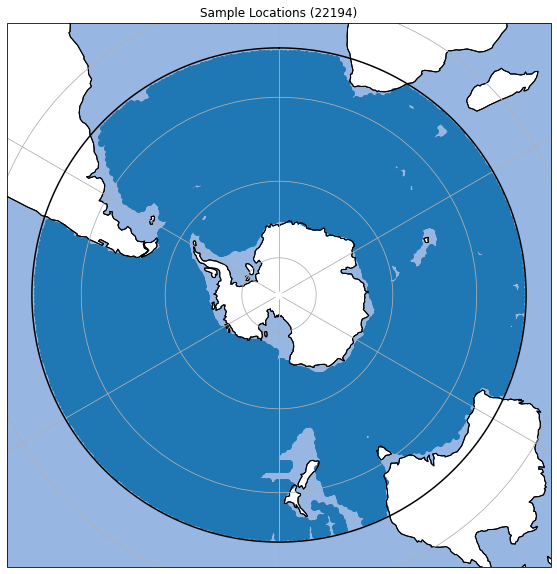

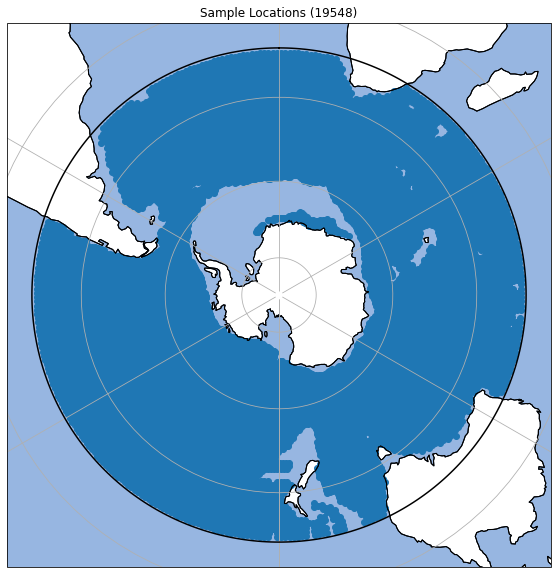

In [14]:
#Mask plotting cell
locationPlotXr(geoRangeFilt, (10,10), 1) #OceanMaskVolcello
locationPlotXr(geoRangeFilt2, (10,10), 2) #OceanMaskUKESM1
plt.show()

<br>

### Anomalies

lat   lon       time  labelSorted  max posterior prob  \
49956   -44.646076 -56.5 1980-07-01            0            0.658393   
57501   -44.646076 -58.5 1980-08-01            0            0.705647   
57507   -43.930252 -57.5 1980-08-01            0            0.514154   
65067   -43.930252 -57.5 1980-09-01            0            0.595079   
65076   -44.646076 -56.5 1980-09-01            0            0.843152   
...            ...   ...        ...          ...                 ...   
2683175 -44.646076 -56.5 2009-08-01            0            0.682294   
2690717 -44.646076 -58.5 2009-09-01            0            0.590014   
2690727 -44.646076 -56.5 2009-09-01            0            0.719846   
2691740 -44.646076 -14.5 2009-09-01            0            0.522941   
2698263 -44.646076 -57.5 2009-10-01            0            0.588097   

         classUncertainty  
49956            0.683215  
57501            0.588706  
57507            0.971692  
65067            0.809842  
65076            0.313697  
...                   ...  
2683175          0.635412  
2690717          0.819972  
2690727          0.560308  
2691740          0.954118  
2698263          0.823805  

[1607 rows x 6 columns]

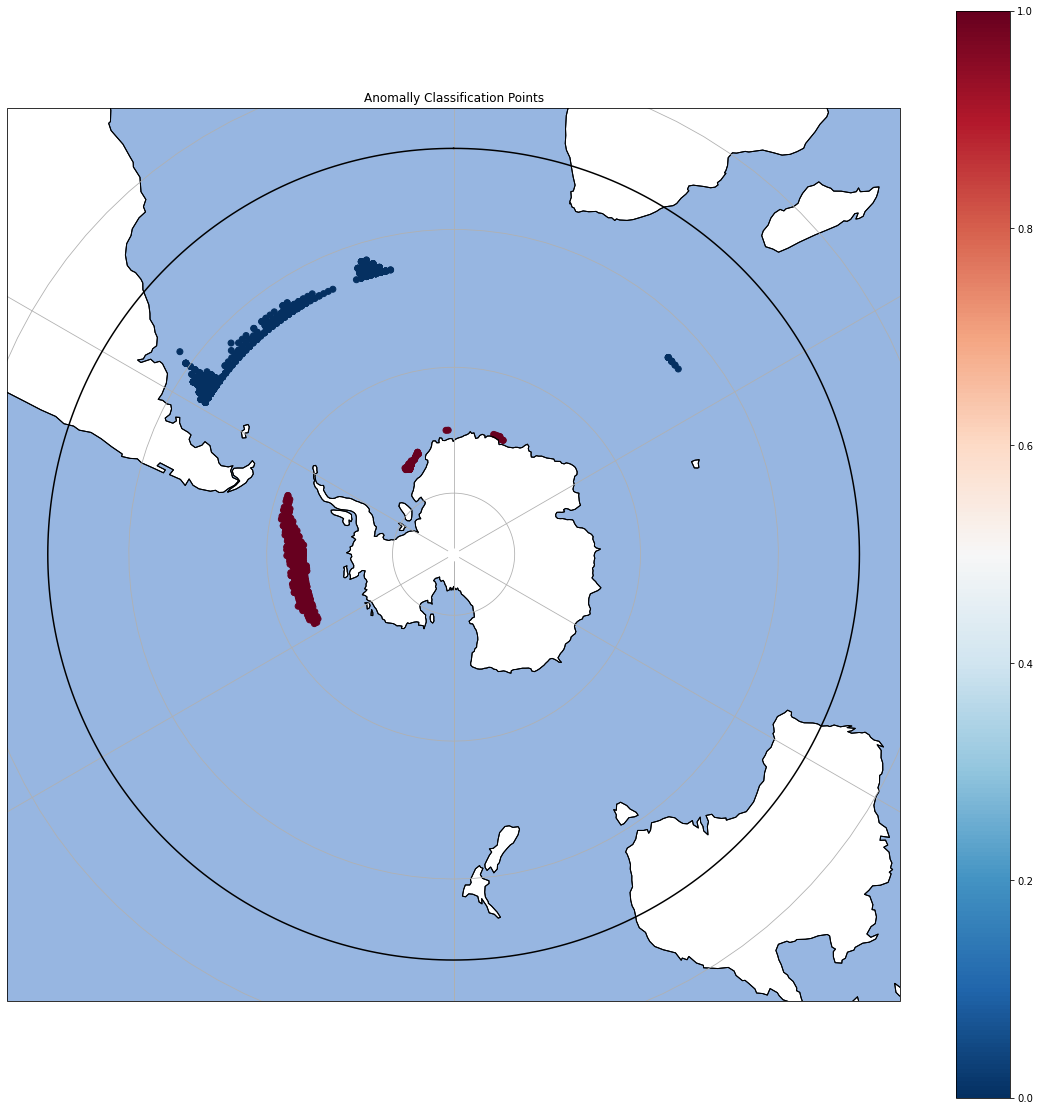

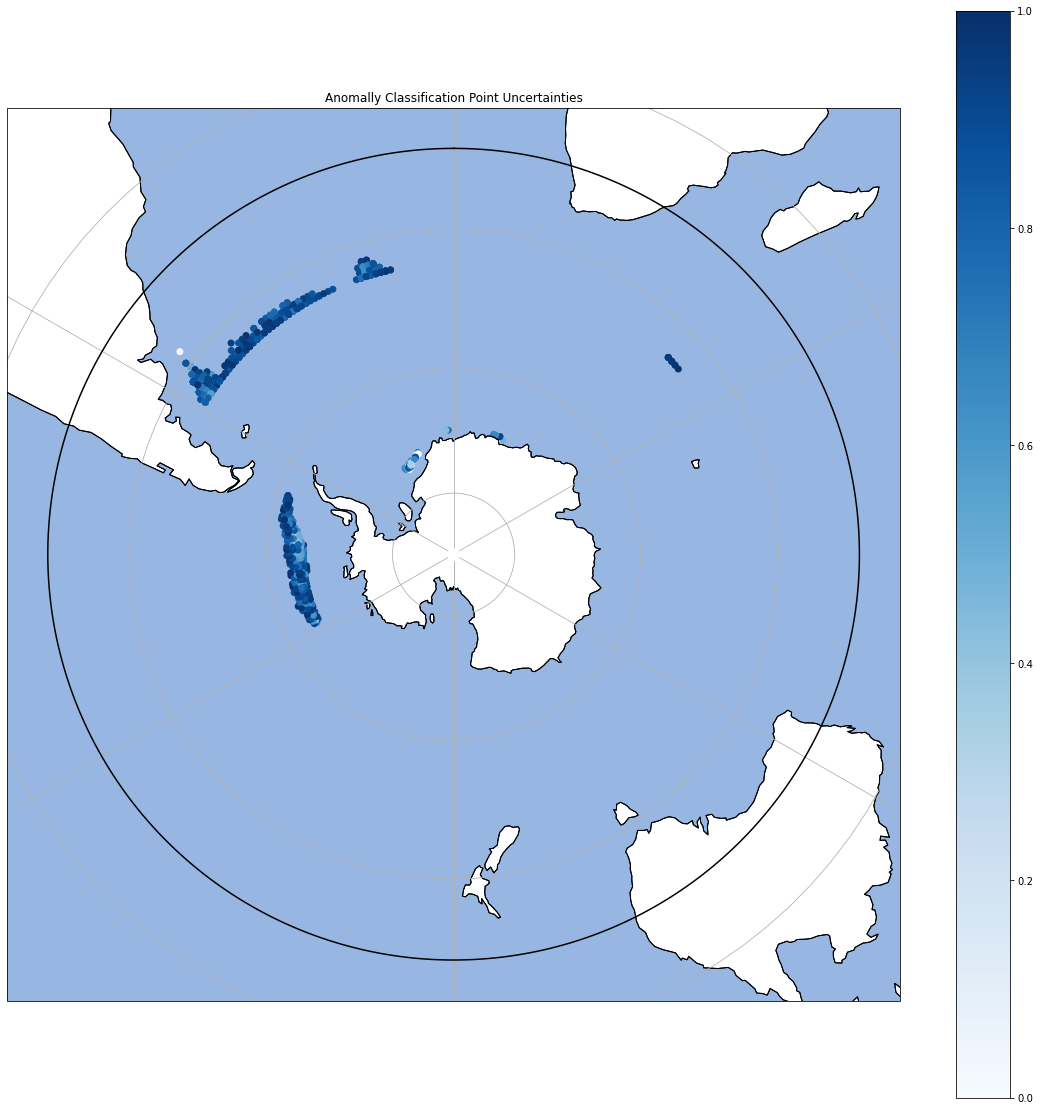

In [136]:
labelAnomDF = sampleMetaDFL[np.logical_or(np.logical_and(sampleMetaDFL["lat"]<-60, sampleMetaDFL["labelSorted"]==1), np.logical_and(sampleMetaDFL["lat"]>-45, sampleMetaDFL["labelSorted"]==0))]
locationPlotGroupDFLab(labelAnomDF, "Anomally Classification Points", (20,20), 1)
locationPlotUncertaintyDF(labelAnomDF, "Anomally Classification Point Uncertainties", (20,20), 2)
labelAnomDF

<br>

### Taking mean properties for each location

### Mean Singular Latitudes over time

In [66]:
thresholds = [0.25, 0.50, 0.75, 0.85]
smoothFactor1 = 24
smoothFactor2 = 120
monthlyLatMMList = []
monthlyLatMMS1List = []
monthlyLatMMS2List = []

for i in range(len(thresholds)):
    uncertaintyDFL = sampleMetaDFL[sampleMetaDFL["classUncertainty"] > thresholds[i]]
    uncertaintyDFLTimeG = uncertaintyDFL.groupby("time")
    monthlyLatMMList.append(uncertaintyDFLTimeG.mean()[["lat"]])
    monthlyLatMMS1List.append(butter_lowpass(monthlyLatMMList[i]["lat"], smoothFactor1))
    monthlyLatMMS2List.append(butter_lowpass(monthlyLatMMList[i]["lat"], smoothFactor2))
print("Monthly Singular Mean Latitudes calculated, with smoothing.")

Monthly Singular Mean Latitudes calculated, with smoothing.


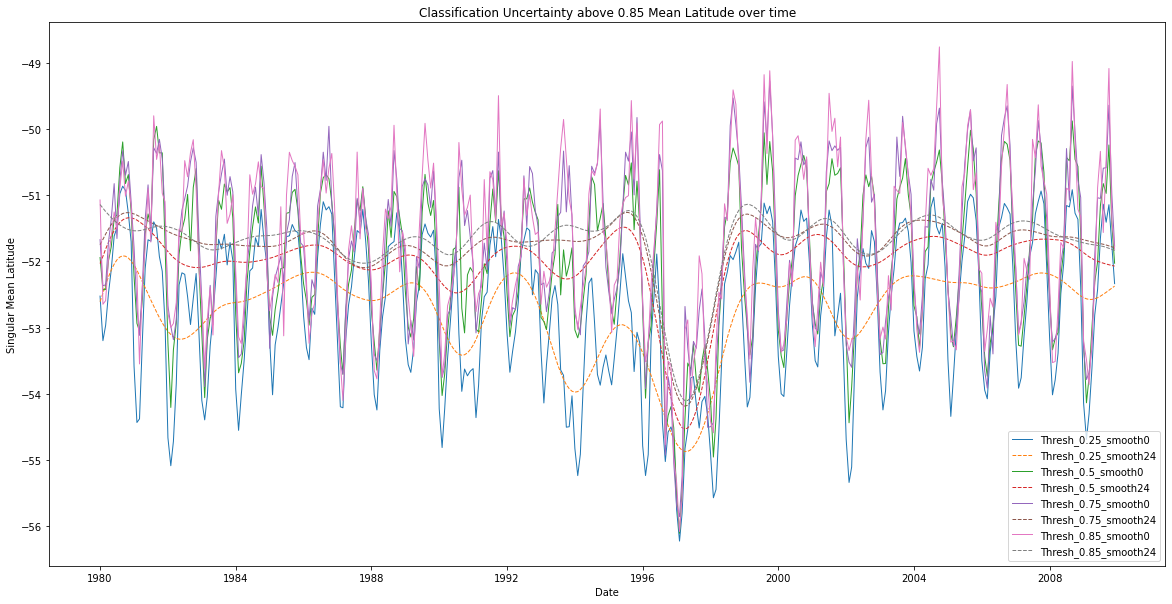

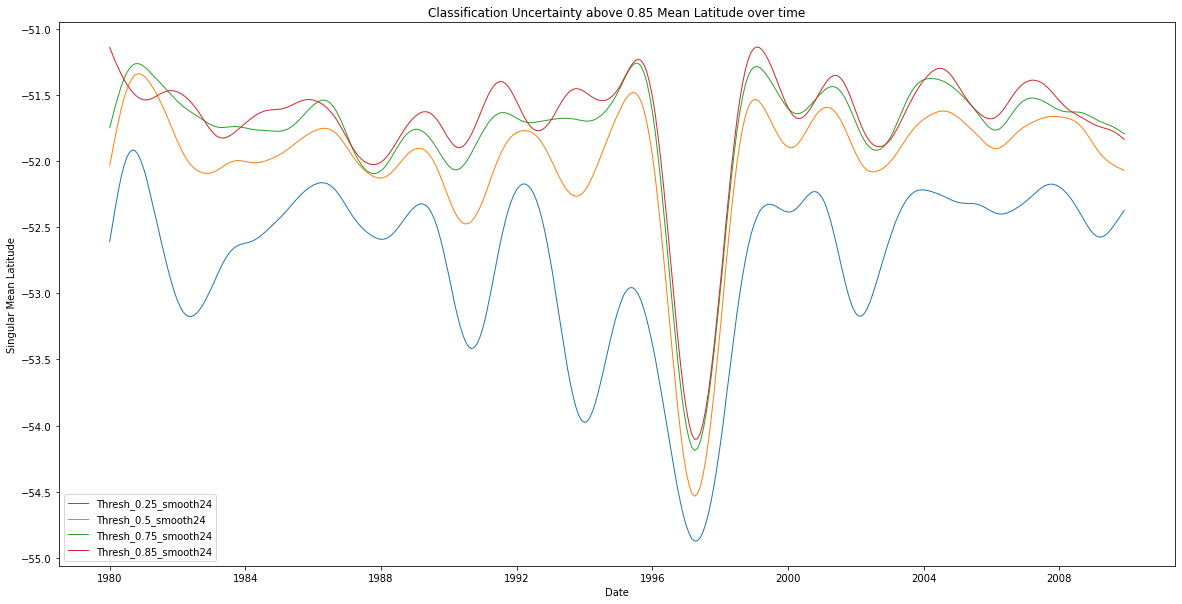

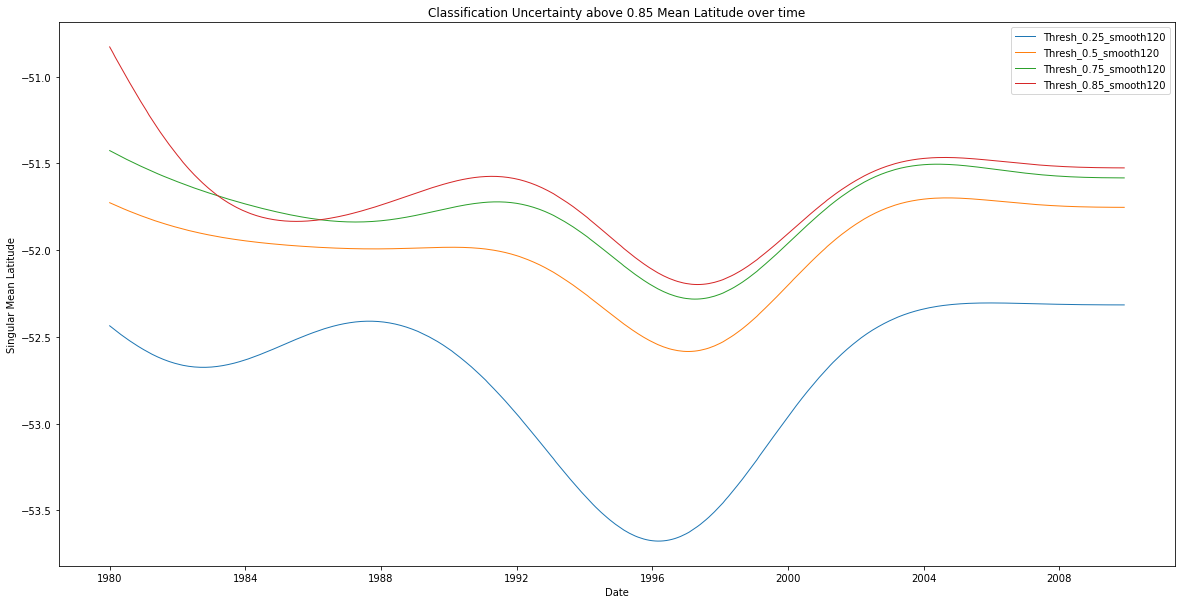

In [16]:
for i in range(len(thresholds)):
    timeSingleLatMean(monthlyLatMMList[i], "-", thresholds[i], 0, 1)
    timeSingleLatMean(monthlyLatMMS1List[i], "--", thresholds[i], smoothFactor1, 1)
    
    timeSingleLatMean(monthlyLatMMS1List[i], "-", thresholds[i], smoothFactor1, 2)
    timeSingleLatMean(monthlyLatMMS2List[i], "-", thresholds[i], smoothFactor2, 3)
plt.show()

### 1997 Dip investigation

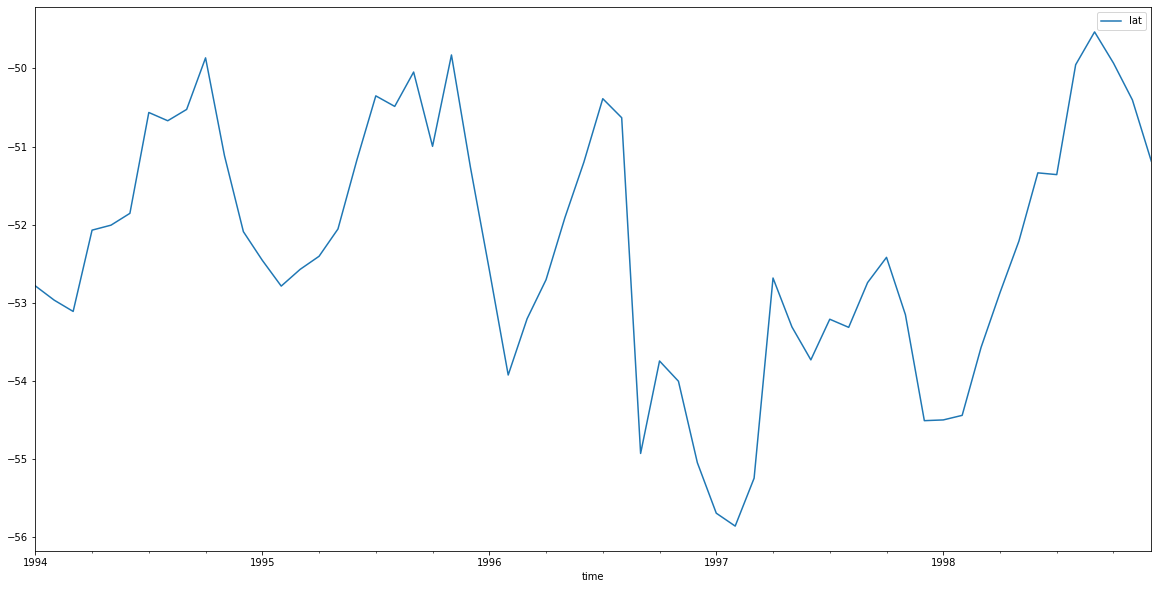

In [106]:
timeRange = np.arange(np.datetime64("1994-01",'M'), np.datetime64("1999-01", 'M'), np.timedelta64(1, 'M'))
breakDown = monthlyLatMMList[2]
timeRangeDF = breakDown[breakDown.index.isin(timeRange)]
timeRangeDF.plot(figsize=(20,10))
plt.show()

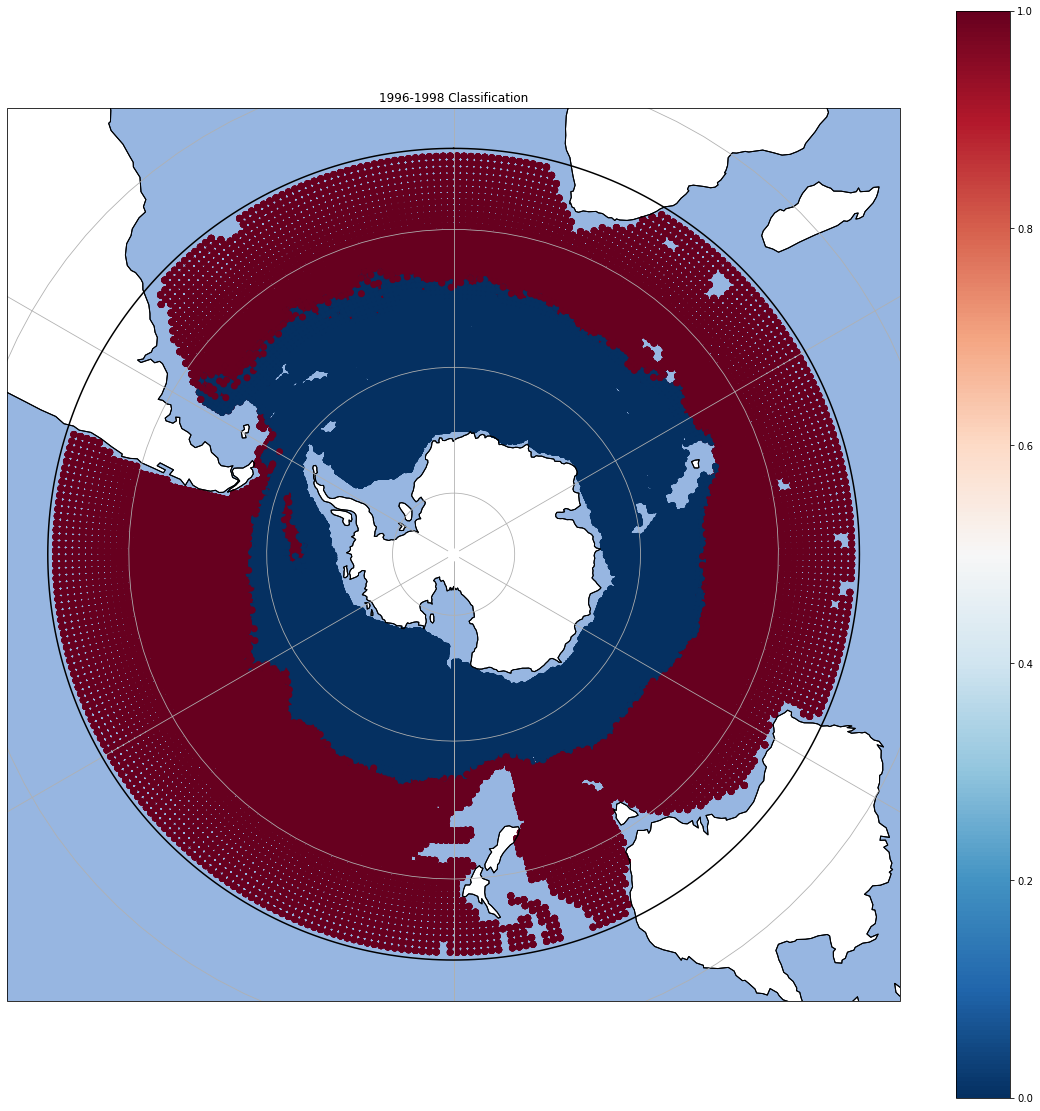

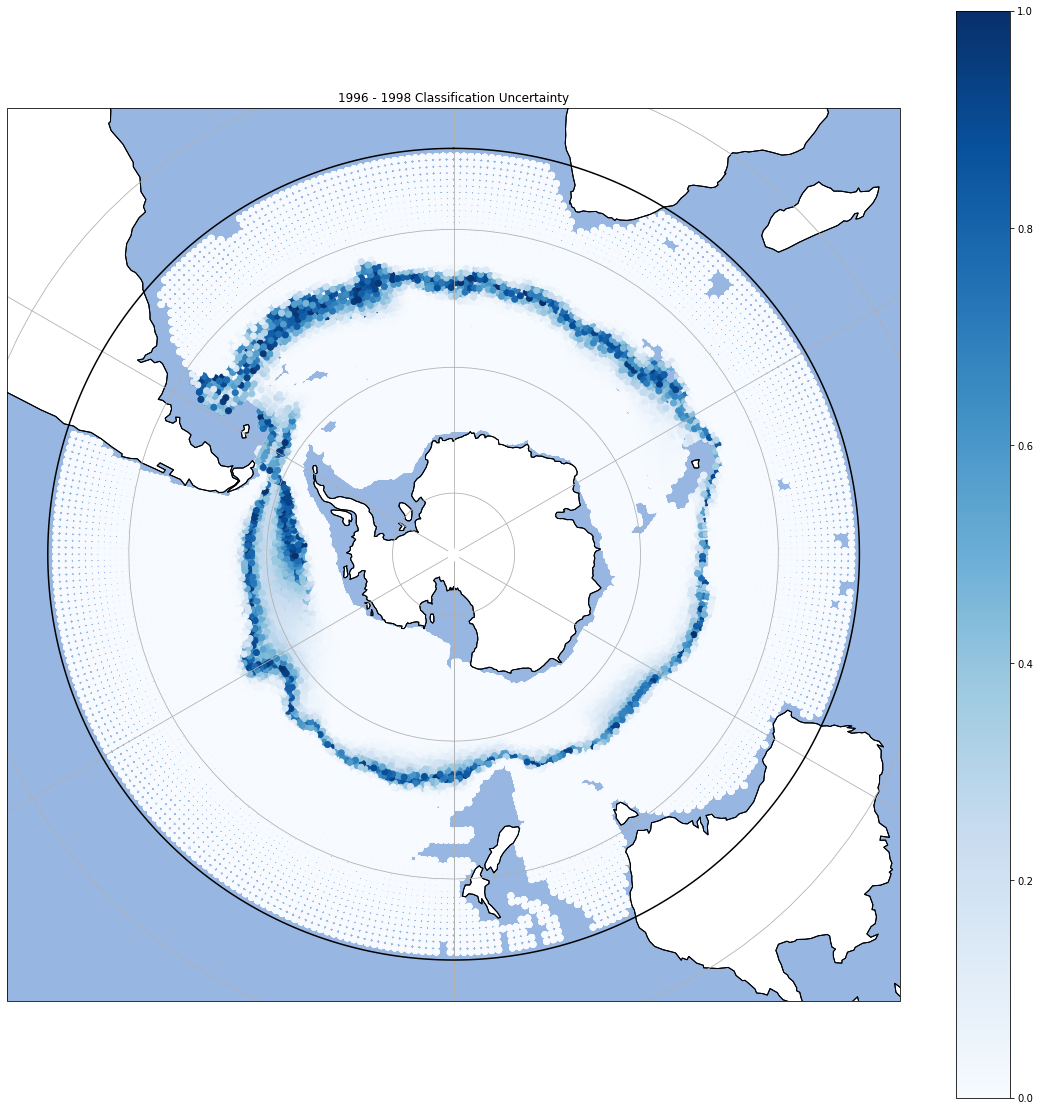

In [105]:
timeRangeClose = np.arange(np.datetime64("1996-01",'M'), np.datetime64("1998-01", 'M'), np.timedelta64(1, 'M'))
timeRangeCloseDF = sampleMetaDFL[sampleMetaDFL["time"].isin(timeRangeClose)]
locationPlotGroupDFLab(timeRangeCloseDF, "1996-1998 Classification", (20,20), 1)
locationPlotUncertaintyDF(timeRangeCloseDF, "1996 - 1998 Classification Uncertainty", (20,20), 2)
plt.show()

<br>

### Mean Investigation 

In [65]:
sel = 2
print("Threshold = "+str(thresholds[sel]))
for i in range(len(decades)):
    decadeDF = monthlyLatMMList[sel]
    singularLatMean = decadeDF[decadeDF.index.isin(decadeList[i])].mean()["lat"]
    print("For "+str(decades[i])+" the singular mean latitude was "+str(np.round(singularLatMean, 2))+".")

Threshold = 0.75
For 1980 the singular mean latitude was -51.68.
For 1990 the singular mean latitude was -52.0.
For 2000 the singular mean latitude was -51.62.


### Decadal investigationdecDFIThreshLatMList[i]

In [45]:
decades = ["1980", "1990", "2000"]
decade80 = np.arange(np.datetime64("1980", 'M'), np.datetime64("1990", 'M'), np.timedelta64(1, 'M'))
decade90 = np.arange(np.datetime64("1990", 'M'), np.datetime64("2000", 'M'), np.timedelta64(1, 'M'))
decade00 = np.arange(np.datetime64("2000", 'M'), np.datetime64("2010", 'M'), np.timedelta64(1, 'M'))
decadeList = [decade80, decade90, decade00]
print("Decade lists created and stored in decade80, decade90 and decade00.")

Decade lists created and stored in decade80, decade90 and decade00.


In [18]:
sampleMetaDFDecList = [sampleMetaDFL[sampleMetaDFL["time"].isin(decade80)], sampleMetaDFL[sampleMetaDFL["time"].isin(decade90)], sampleMetaDFL[sampleMetaDFL["time"].isin(decade00)]]
print("Decade split performed and stored in sampleMetaDFDecList.")

Decade split performed and stored in sampleMetaDFDecList.


In [137]:
decDFIThreshList = []
decDFIThreshLatMList = []
decDFIThreshLatSList = []
threshold = 0.75

for i in range(len(decades)):
    decDF = sampleMetaDFDecList[i]
    decDFIThresh = decDF[decDF["classUncertainty"] > threshold]
    decDFIThreshList.append(decDFIThresh)
    
    decDFIThreshLonG = decDFIThresh.groupby("lon")
    decDFIThreshLatMList.append(decDFIThreshLonG.mean()[["lat"]])
    decDFIThreshLatSList.append(decDFIThreshLonG.std()[["lat"]])
print("Decadal class uncertainty latitude means calculted and stored in decDFIThreshLatMList. Standard deviations are stored in decDFIThreshLatSList.")

Decadal class uncertainty latitude means calculted and stored in decDFIThreshLatMList. Standard deviations are stored in decDFIThreshLatSList.


In [138]:
decDFIThreshLatMMList = []
for i in range(len(decDFIThreshLatMList)):
    decDFIThreshLatMMList.append(decDFIThreshLatMList[i]["lat"].mean())
    print("For "+str(decades[i])+" the singular mean latitude for a threshold of "+str(threshold)+" was "+str(np.round(decDFIThreshLatMMList[i], 2))+".")
print("Decade singular mean latitude values calculated.")

For 1980 the singular mean latitude for a threshold of 0.75 was -52.69.
For 1990 the singular mean latitude for a threshold of 0.75 was -52.2.
For 2000 the singular mean latitude for a threshold of 0.75 was -52.06.
Decade singular mean latitude values calculated.


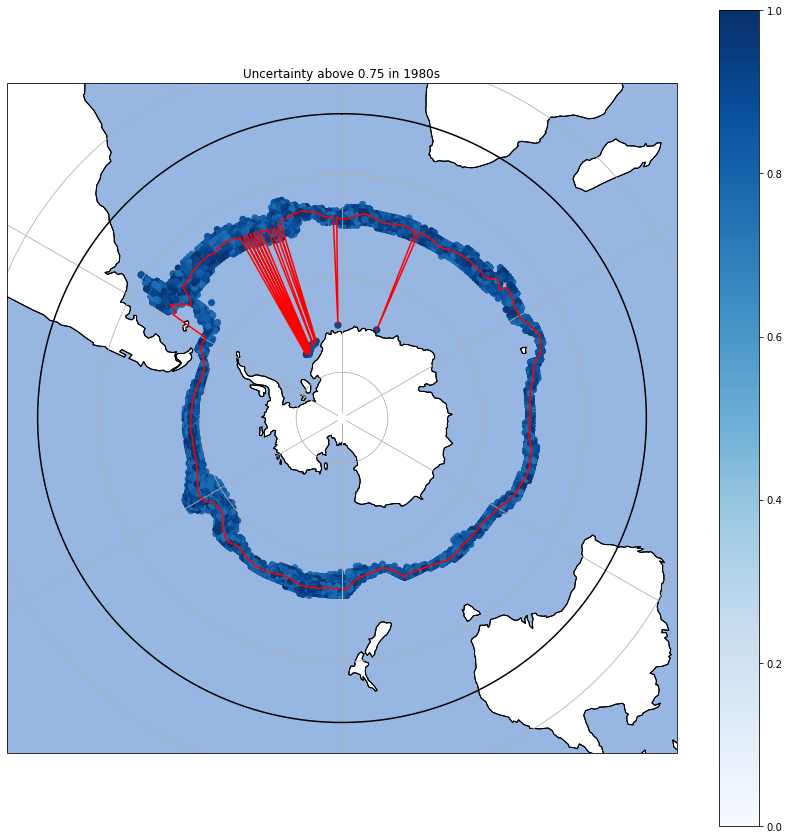

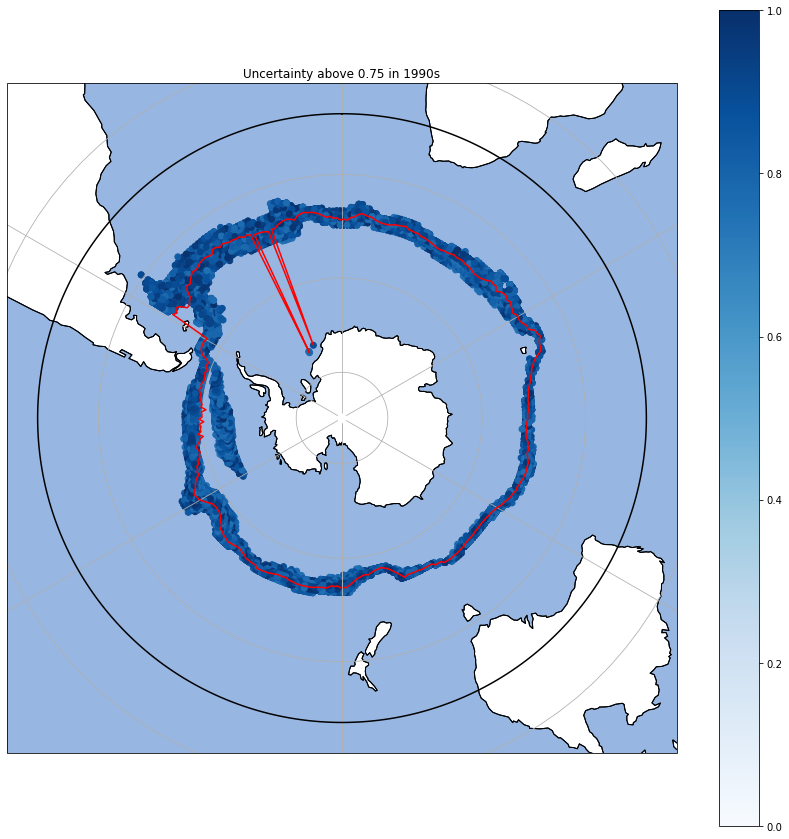

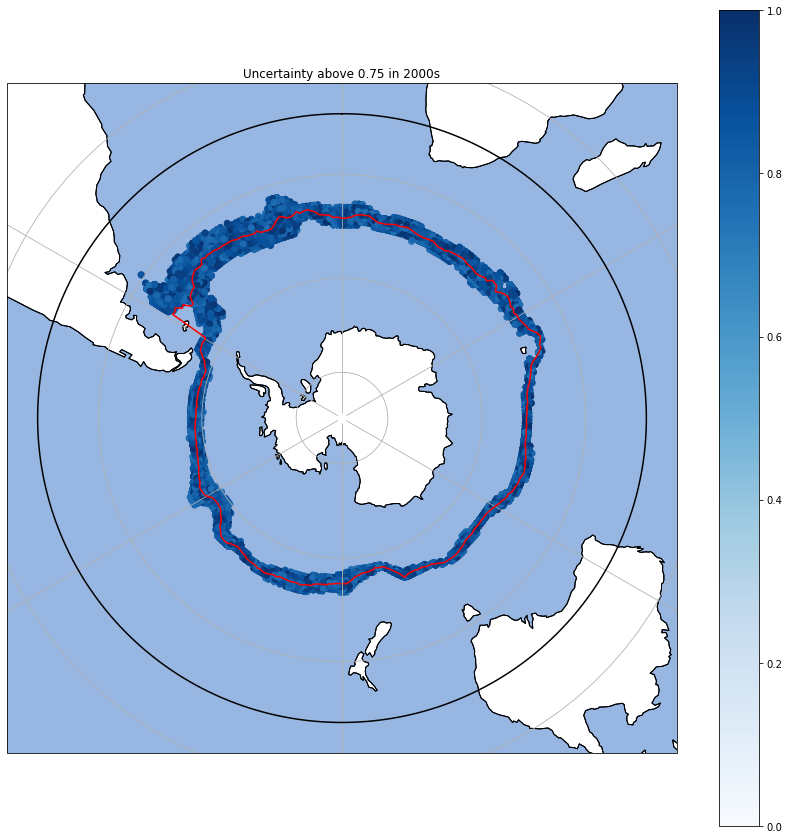

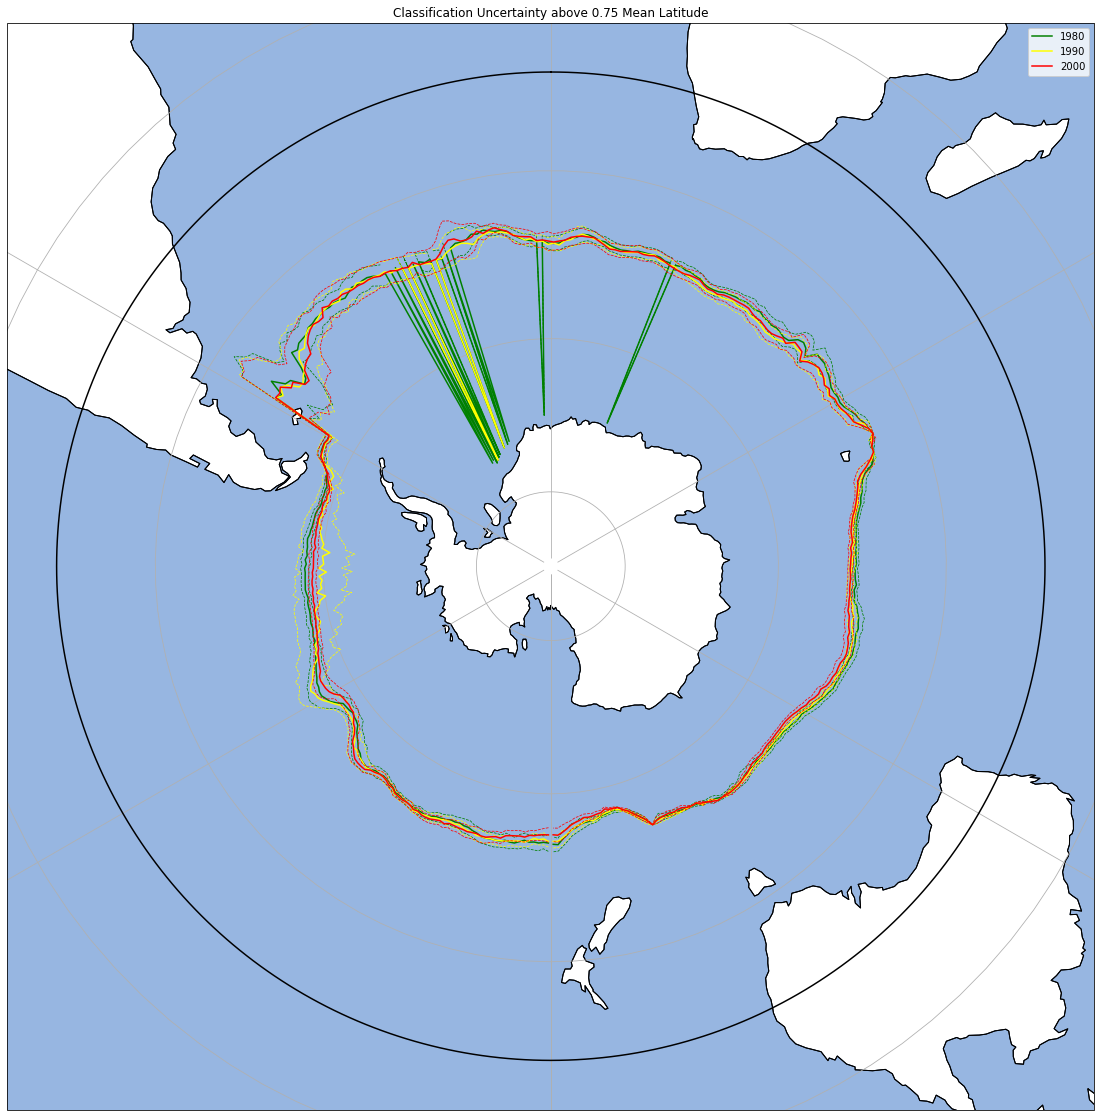

In [139]:
for i in range(len(decades)):    
    locationPlotUncertaintyDF(decDFIThreshList[i], "Uncertainty above "+str(threshold)+" in "+decades[i]+"s", (15,15), i)
    plt.plot(decDFIThreshLatMList[i].index, decDFIThreshLatMList[i]["lat"], transform=ccrs.PlateCarree(), color="red")
    
locationUncertaintyMean(decDFIThreshLatMList, decDFIThreshLatSList, threshold, (20,20), 4)
plt.show()

<br>

### Plotting location and cluster

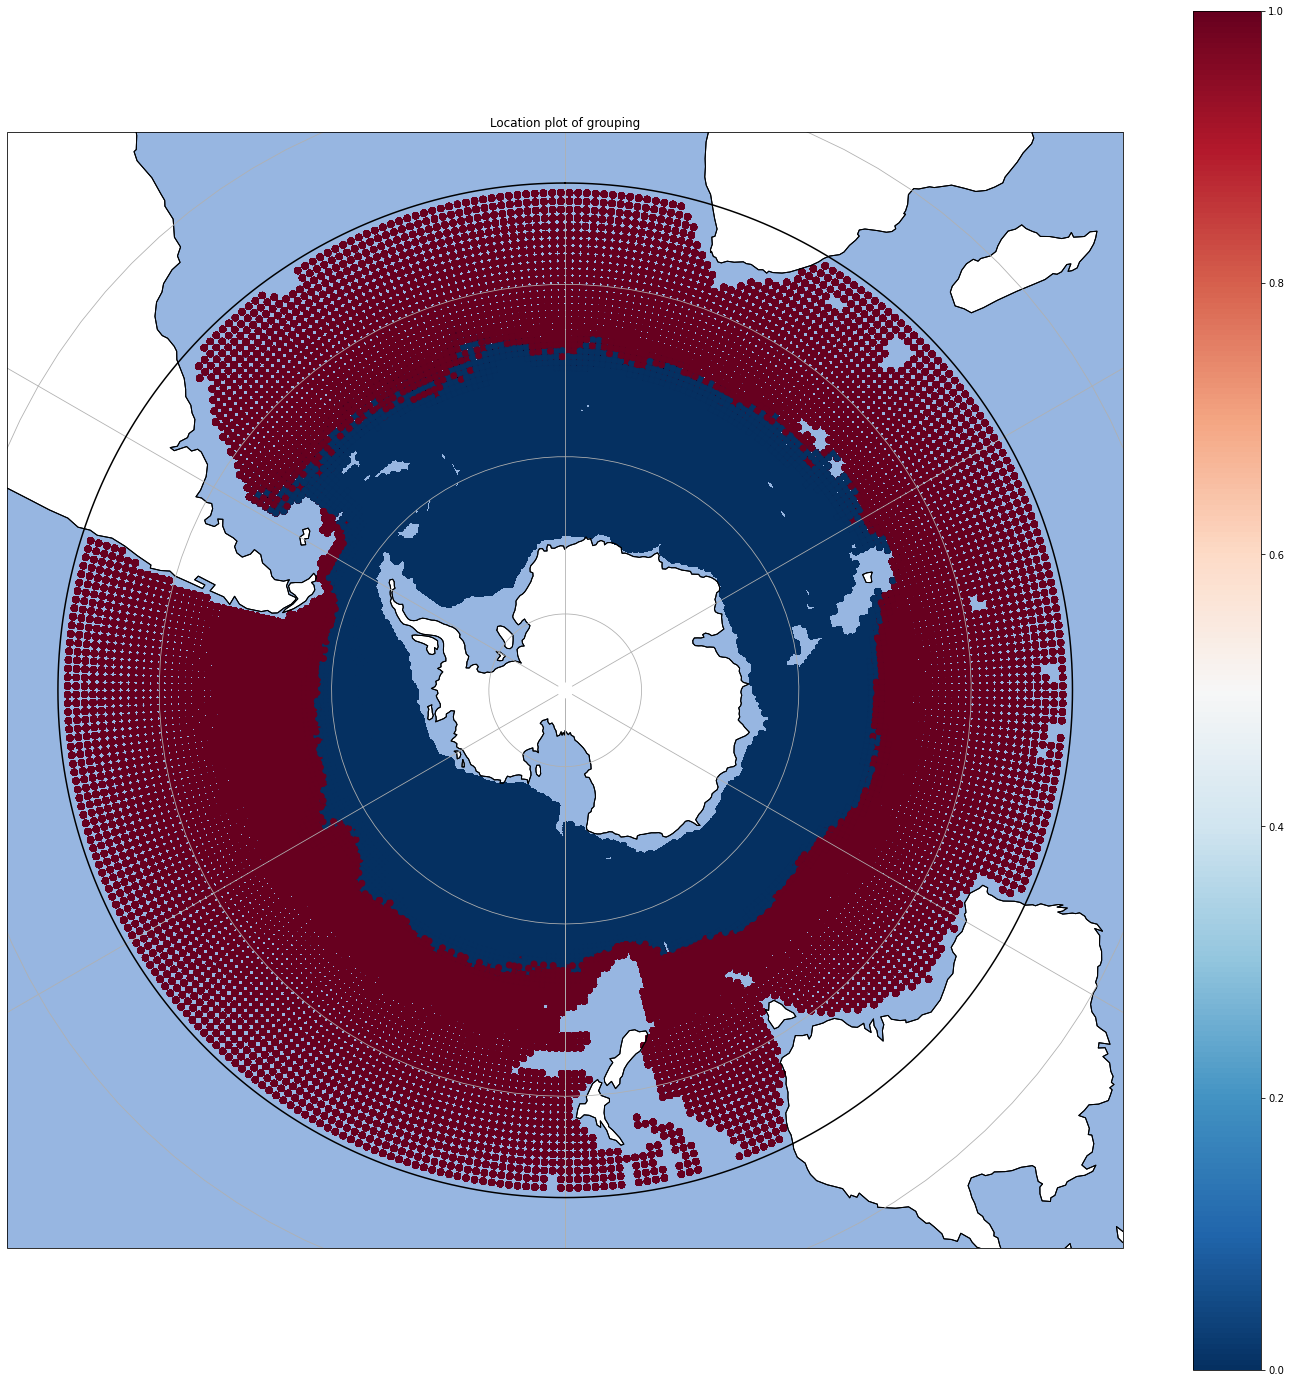

In [22]:
locationPlotGroupDFLab(sampleMetaDFL, "Location plot of grouping", (25,25), 1)
plt.show()

Classifications, grouped by month.


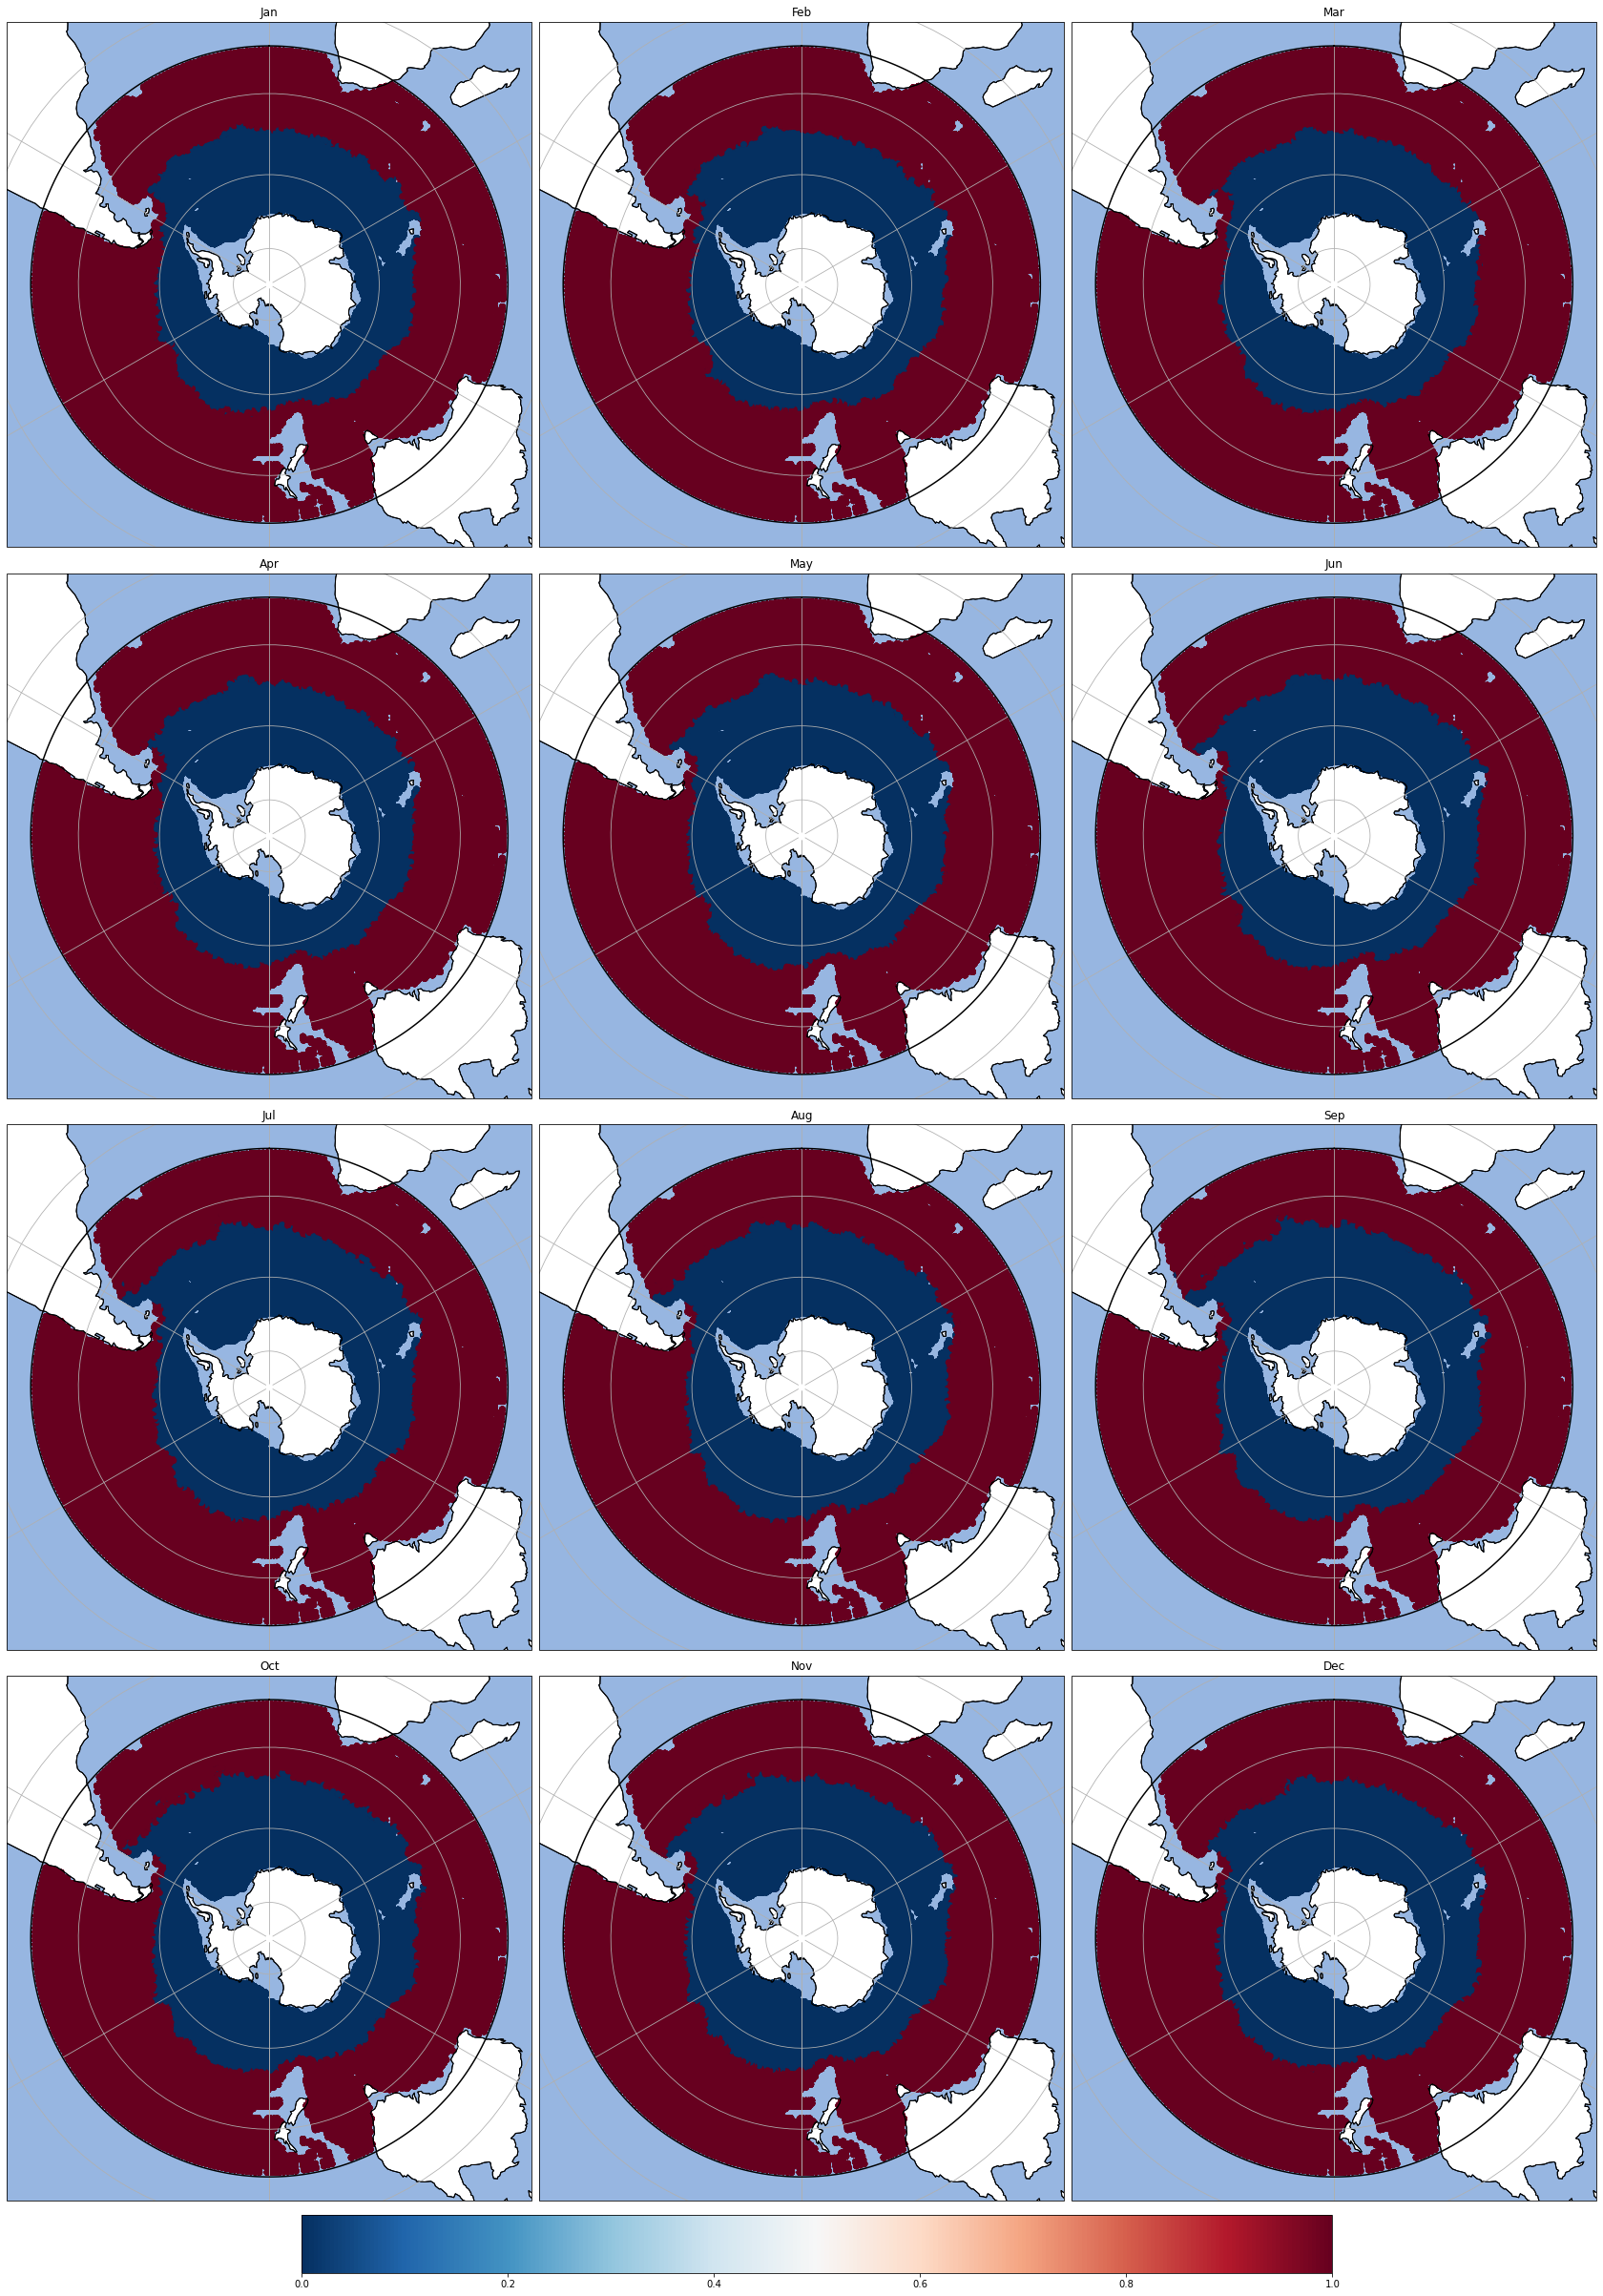

In [23]:
locationPlotGroupDFMonthly(sampleMetaDFL, "Monthly summaries for training data set", 1)
print("Classifications, grouped by month.")
plt.show()

Uncertainty in classifications, grouped by month.


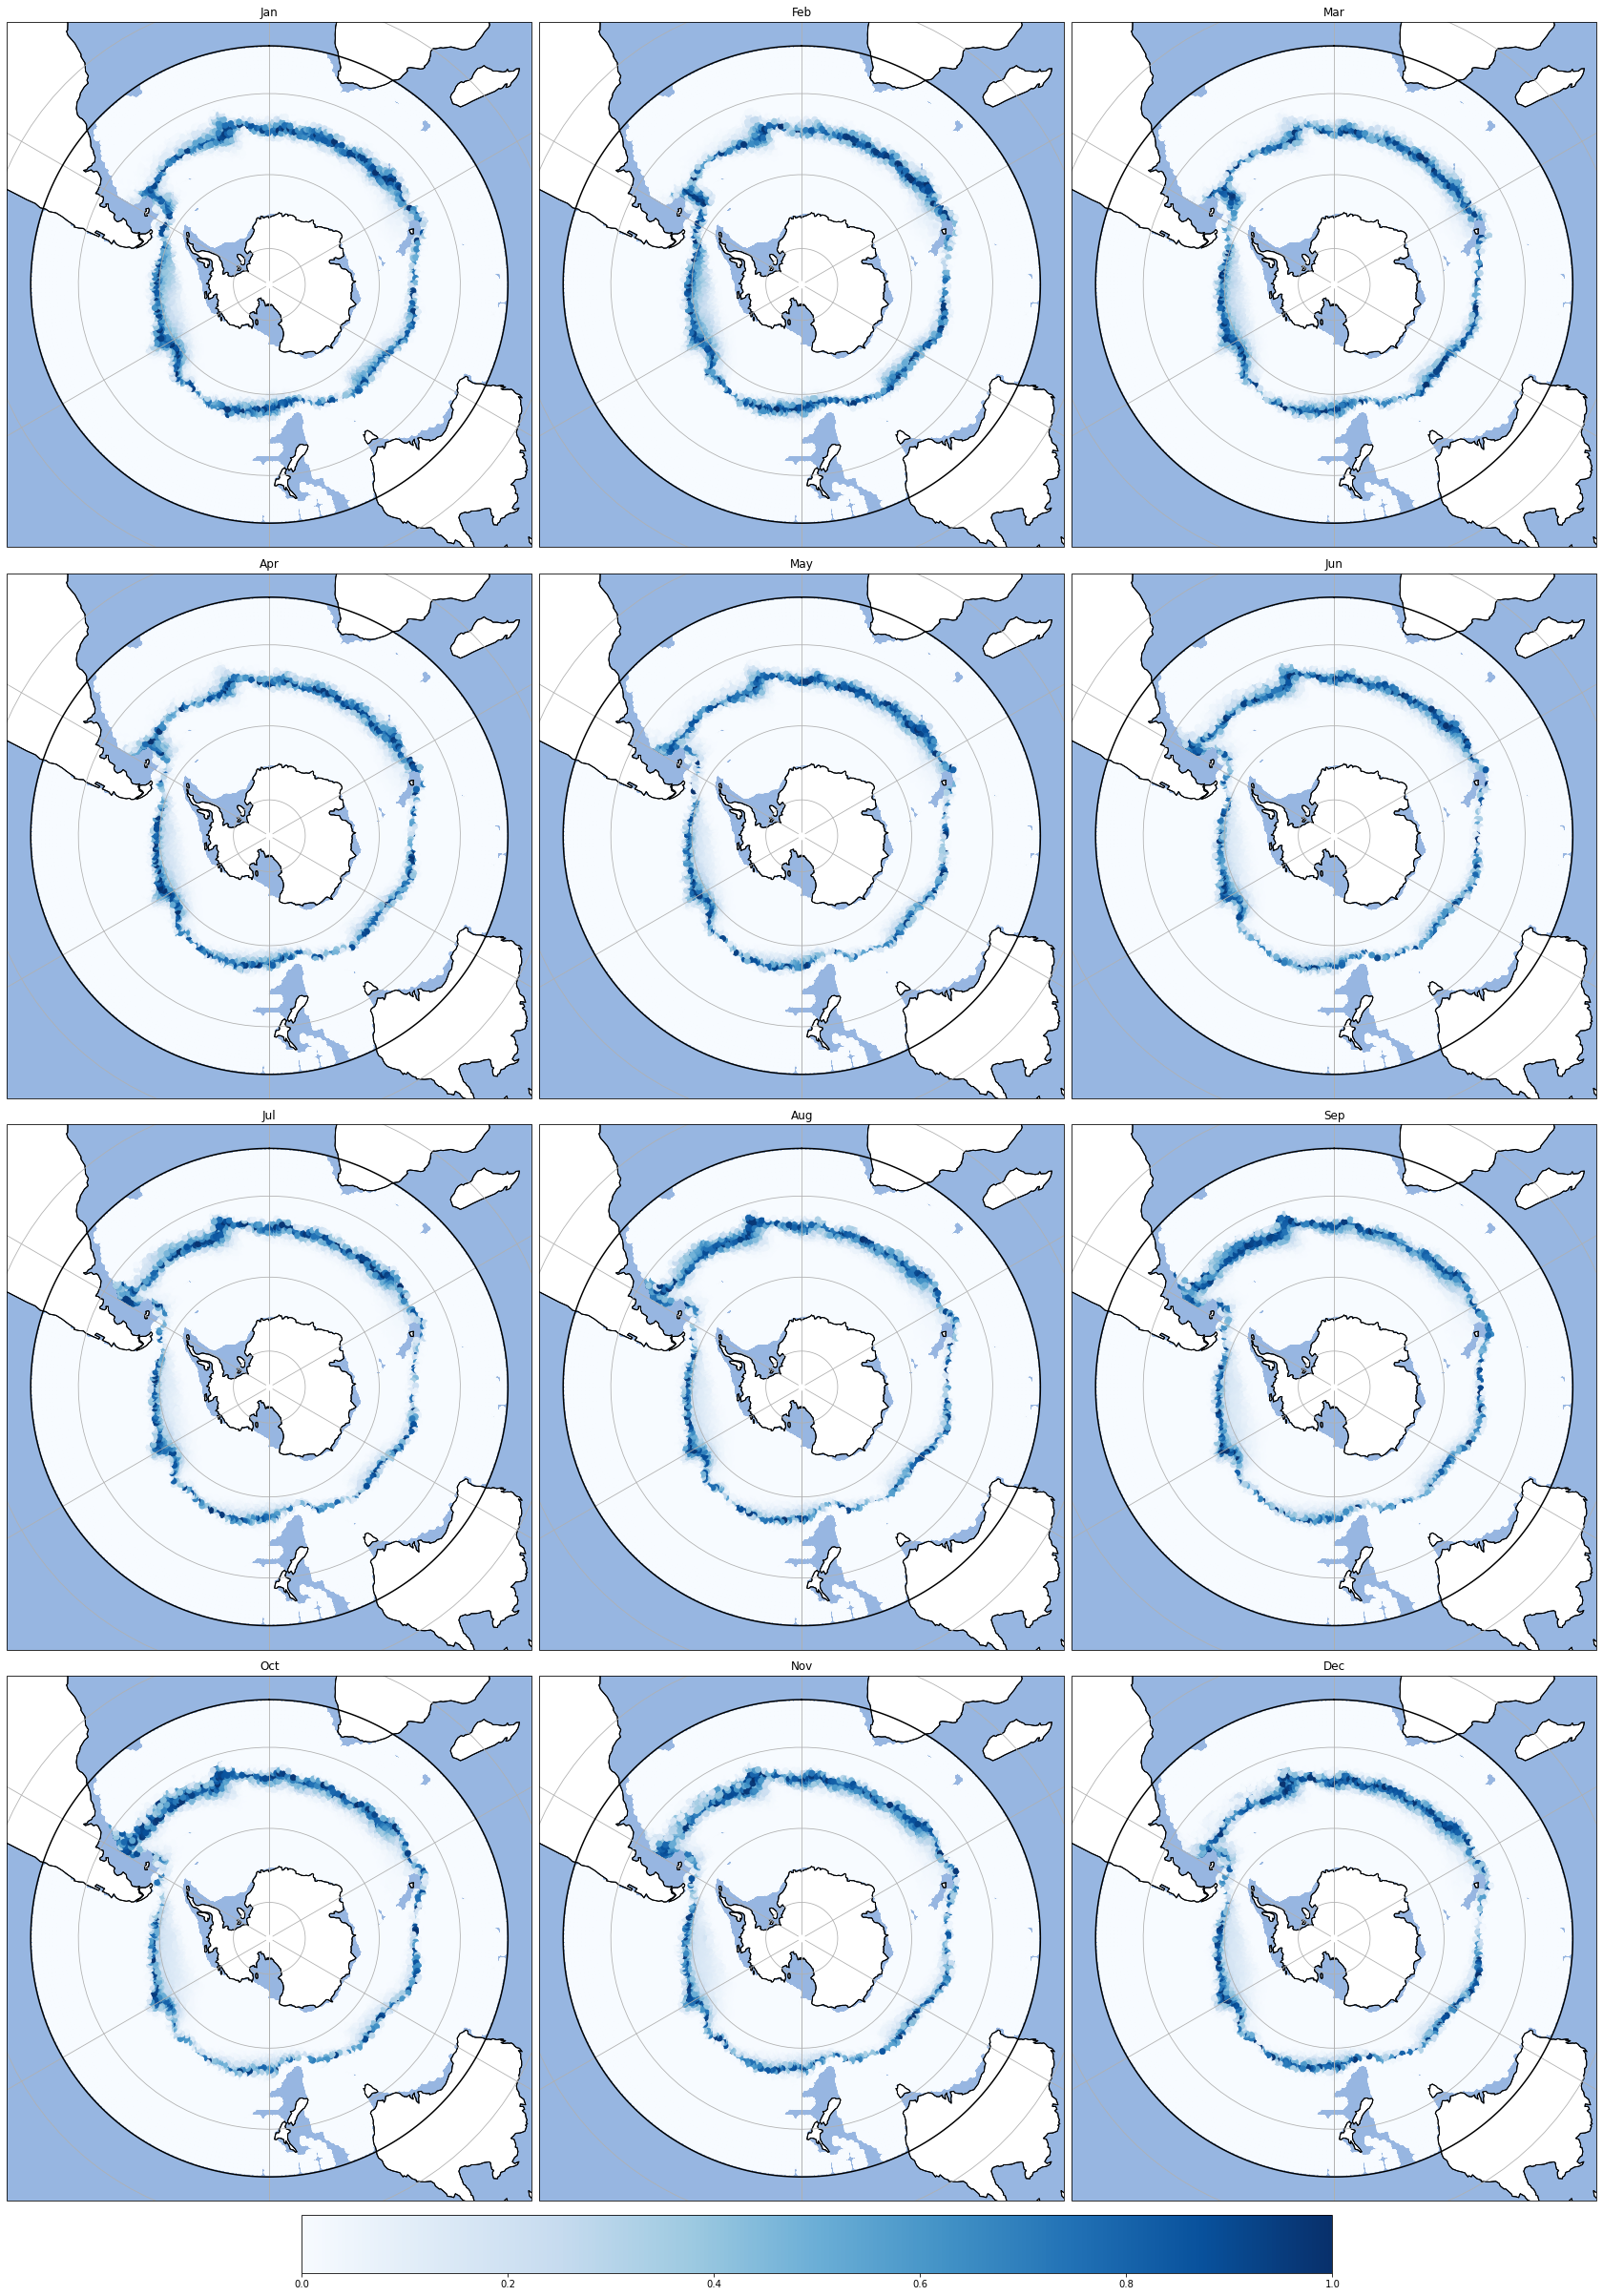

In [24]:
locationPlotUncertaintyDFMonthly(sampleMetaDFL, "Monthly uncertainty", 1)
print("Uncertainty in classifications, grouped by month.")
plt.show()

<br>